# Data Input

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm # Note: Do not do import pymc as pm for Version >= 4.0
from tqdm.notebook import tqdm

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [2]:
dic_country = \
{'AUS': 'Australia',
 'BRA': 'Brazil',
 'CAN': 'India',
 'CHN': 'China',
 'GBR': 'United Kingdom',
 'IND': 'India',
 'JPN': 'Japan',
 'SGP': 'Singapore',
 'USA': 'United States'}
pd.DataFrame(dic_country,index=[0]).T.reset_index().rename(columns = {'index': 'country_code', 0: 'country_name'})

,country_code,country_name
0,AUS,Australia
1,BRA,Brazil
2,CAN,India
3,CHN,China
4,GBR,United Kingdom
5,IND,India
6,JPN,Japan
7,SGP,Singapore
8,USA,United States


In [3]:
Data_dic_m = pd.ExcelFile('../../Data/cleaned/Manufacturing_filled.xlsx')
Data_dic_s = pd.ExcelFile('../../Data/cleaned/Service_filled.xlsx')

In [4]:
def get_sheet_by_methods(data, method_num, verbose = 0):
  sheet_names = data.sheet_names
  sheet_imputation_map = pd.DataFrame([[s, s[:3].strip(),s[3:]] for s in sheet_names], columns = ['sheet_name', 'country_code', 'imputation method'])
  methods = sheet_imputation_map['imputation method'].unique()
  if verbose:
    print('methods tried:',methods, len(methods))
  return list(sheet_imputation_map.loc[sheet_imputation_map['imputation method'] == methods[method_num]]['sheet_name'].values)

In [5]:
m_dfs = {}
for i in range(len(Data_dic_m.sheet_names) // 10):
  for sheet in get_sheet_by_methods(Data_dic_m, i):
    df = pd.read_excel(Data_dic_m, sheet_name=sheet)
    df['Year'] = [i.year for i in pd.to_datetime(df.Year, format='%Y')]
    df = df.set_index('Year')
    m_dfs[(sheet[:3], sheet[3:].strip())] = df

In [6]:
s_dfs = {}
for i in range(len(Data_dic_s.sheet_names) // 10):
  for sheet in get_sheet_by_methods(Data_dic_s, i):
    df = pd.read_excel(Data_dic_s, sheet_name=sheet)
    df['Year'] = [i.year for i in pd.to_datetime(df.Year, format='%Y')]
    df = df.set_index('Year')
    s_dfs[(sheet[:3], sheet[3:].strip())] = df

In [7]:
datas_m = {}
for con in dic_country.keys():
    datas_m[con] = m_dfs[(con, "Rolling statistics")]

In [8]:
datas_s = {}
for con in dic_country.keys():
    datas_s[con] = s_dfs[(con, "Rolling statistics")]

In [9]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

# 1 series case

The model we'll fit, for now, will just be

$$\text{Percentage of value added} \sim \alpha + \beta\ \text{time}$$

First, let's try using the default priors set by prophet, and we'll do a prior predictive check:

In [10]:
data = datas_m['IND'].reset_index()

In [11]:
# Scale time to be between 0 and 1
t = data["Year"].to_numpy()
t_min = np.min(t)
t_max = np.max(t)
t = (t - t_min) / (t_max - t_min)

# For the target variable, we divide by the maximum.
    #  We do this, rather than standardising, so that the sign of the observations in unchanged - this will be necessary for the seasonality component to work properly later on.
y = data["Manufacturing_value added_%_of_GDP"].to_numpy()
y_max = np.max(y)
y = y / y_max

Sampling: [likelihood, α, β, σ]


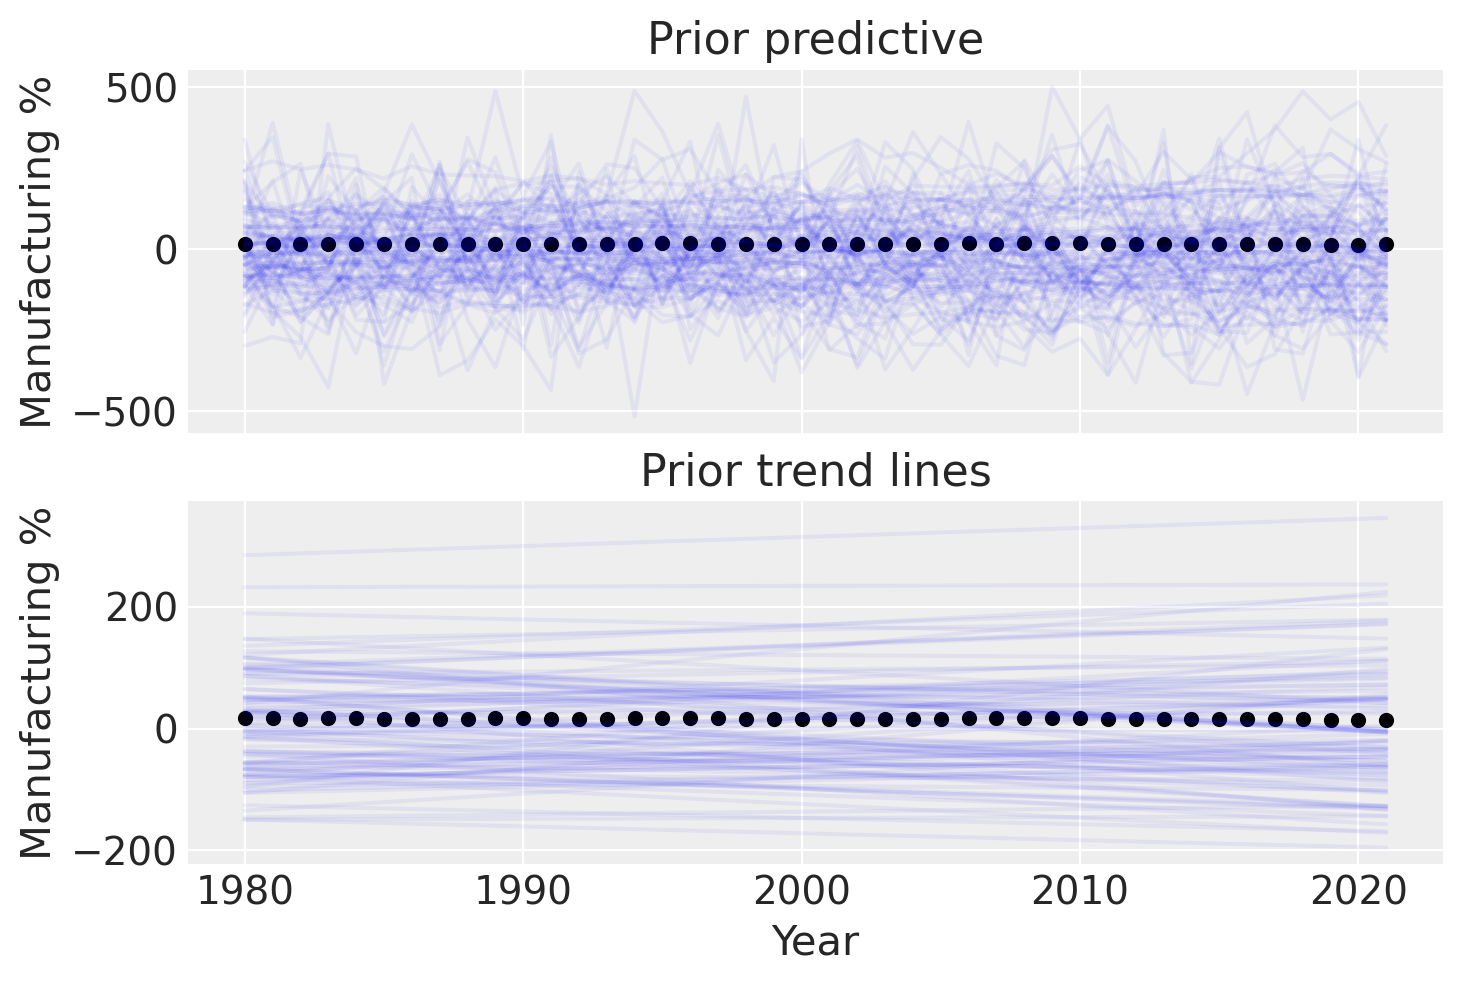

In [12]:
# Generate model with default prophet setting
with pm.Model(check_bounds=False) as linear:
    α = pm.Normal("α", mu=0, sigma=5)
    β = pm.Normal("β", mu=0, sigma=5)
    σ = pm.HalfNormal("σ", sigma=5)
    trend = pm.Deterministic("trend", α + β * t)
    pm.Normal("likelihood", mu=trend, sigma=σ, observed=y)
    linear_prior = pm.sample_prior_predictive()
    
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    data["Year"],
    az.extract(linear_prior, group="prior_predictive", num_samples=100)["likelihood"]
    * y_max,
    color="blue",
    alpha=0.05,
)
data.plot.scatter(x="Year", y="Manufacturing_value added_%_of_GDP", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")
ax[0].set_ylabel("Manufacturing %")

ax[1].plot(
    data["Year"],
    az.extract(linear_prior, group="prior", num_samples=100)["trend"] * y_max,
    color="blue",
    alpha=0.05,
)
data.plot.scatter(x="Year", y="Manufacturing_value added_%_of_GDP", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines");
ax[1].set_ylabel("Manufacturing %")
plt.show()

We can do better than this. These priors are evidently too wide, as we end up with implausibly % higher than 100 / below 0, suggesting setting tighter priors.

Sampling: [likelihood, α, β, σ]


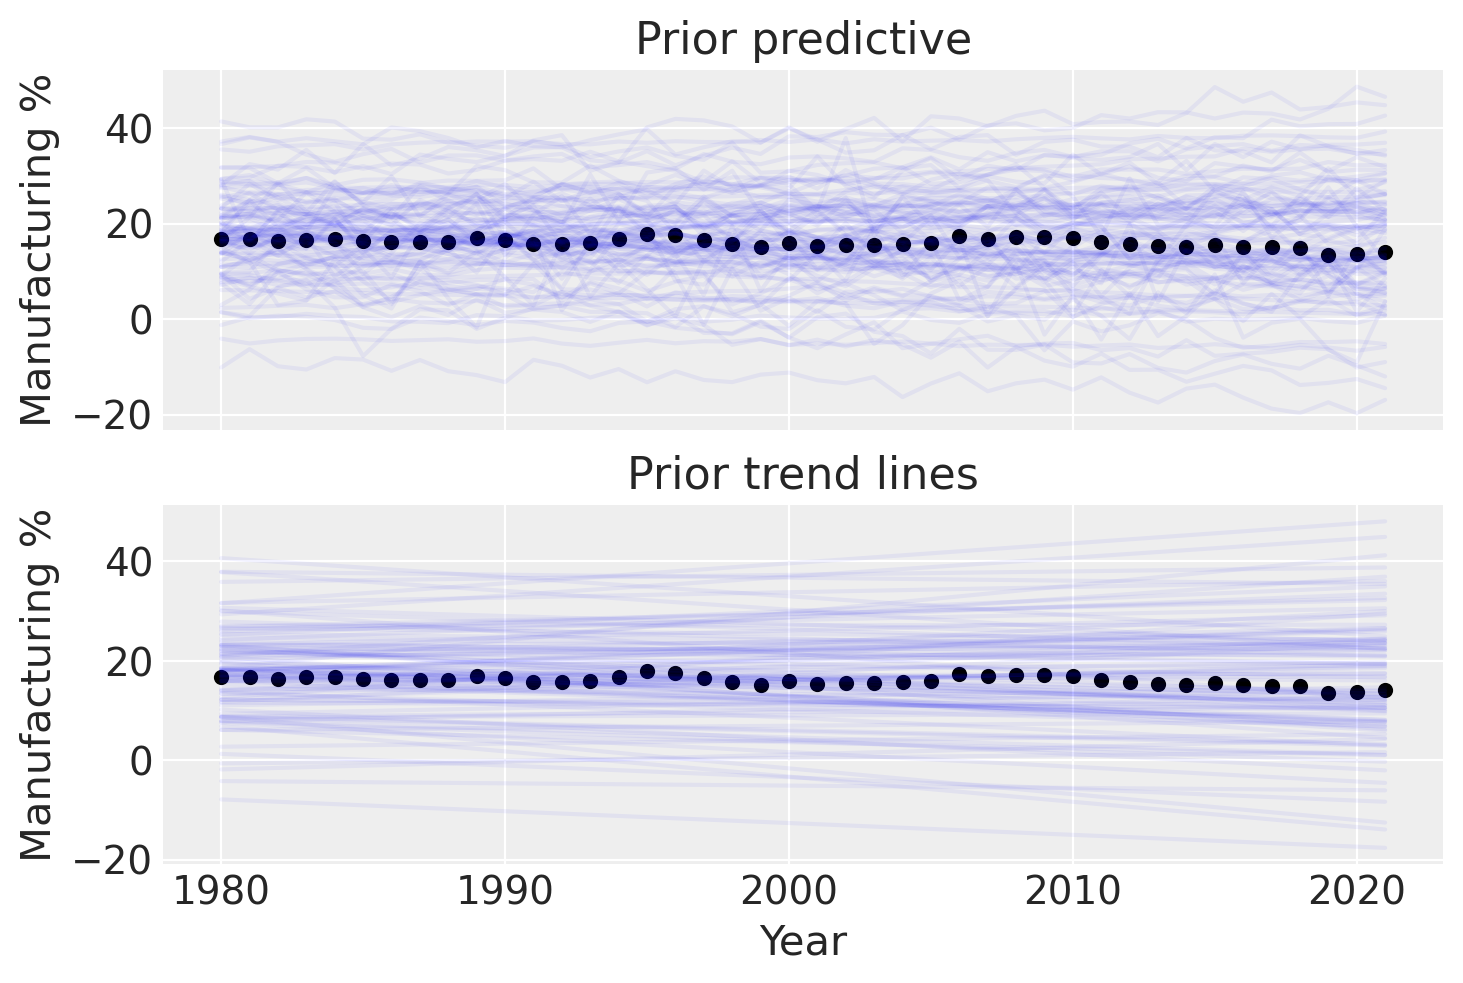

In [13]:
with pm.Model(check_bounds=False) as linear:
    α = pm.Normal("α", mu=1, sigma=0.5)
    β = pm.Normal("β", mu=0, sigma=0.5)
    σ = pm.HalfNormal("σ", sigma=0.1)
    trend = pm.Deterministic("trend", α + β * t)
    pm.Normal("likelihood", mu=trend, sigma=σ, observed=y)

    linear_prior = pm.sample_prior_predictive(samples=100)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    data["Year"],
    az.extract(linear_prior, group="prior_predictive", num_samples=100)["likelihood"]
    * y_max,
    color="blue",
    alpha=0.05,
)
data.plot.scatter(x="Year", y="Manufacturing_value added_%_of_GDP", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")
ax[0].set_ylabel("Manufacturing %")

ax[1].plot(
    data["Year"],
    az.extract(linear_prior, group="prior", num_samples=100)["trend"] * y_max,
    color="blue",
    alpha=0.05,
)
data.plot.scatter(x="Year", y="Manufacturing_value added_%_of_GDP", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines")
ax[1].set_ylabel("Manufacturing %")
plt.show()

Cool. Before going on to anything more complicated, let's try conditioning on the data and doing a posterior predictive check:

In [14]:
with linear:
    linear_trace = pm.sample(return_inferencedata=True)
    linear_prior = pm.sample_posterior_predictive(trace=linear_trace)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [likelihood]


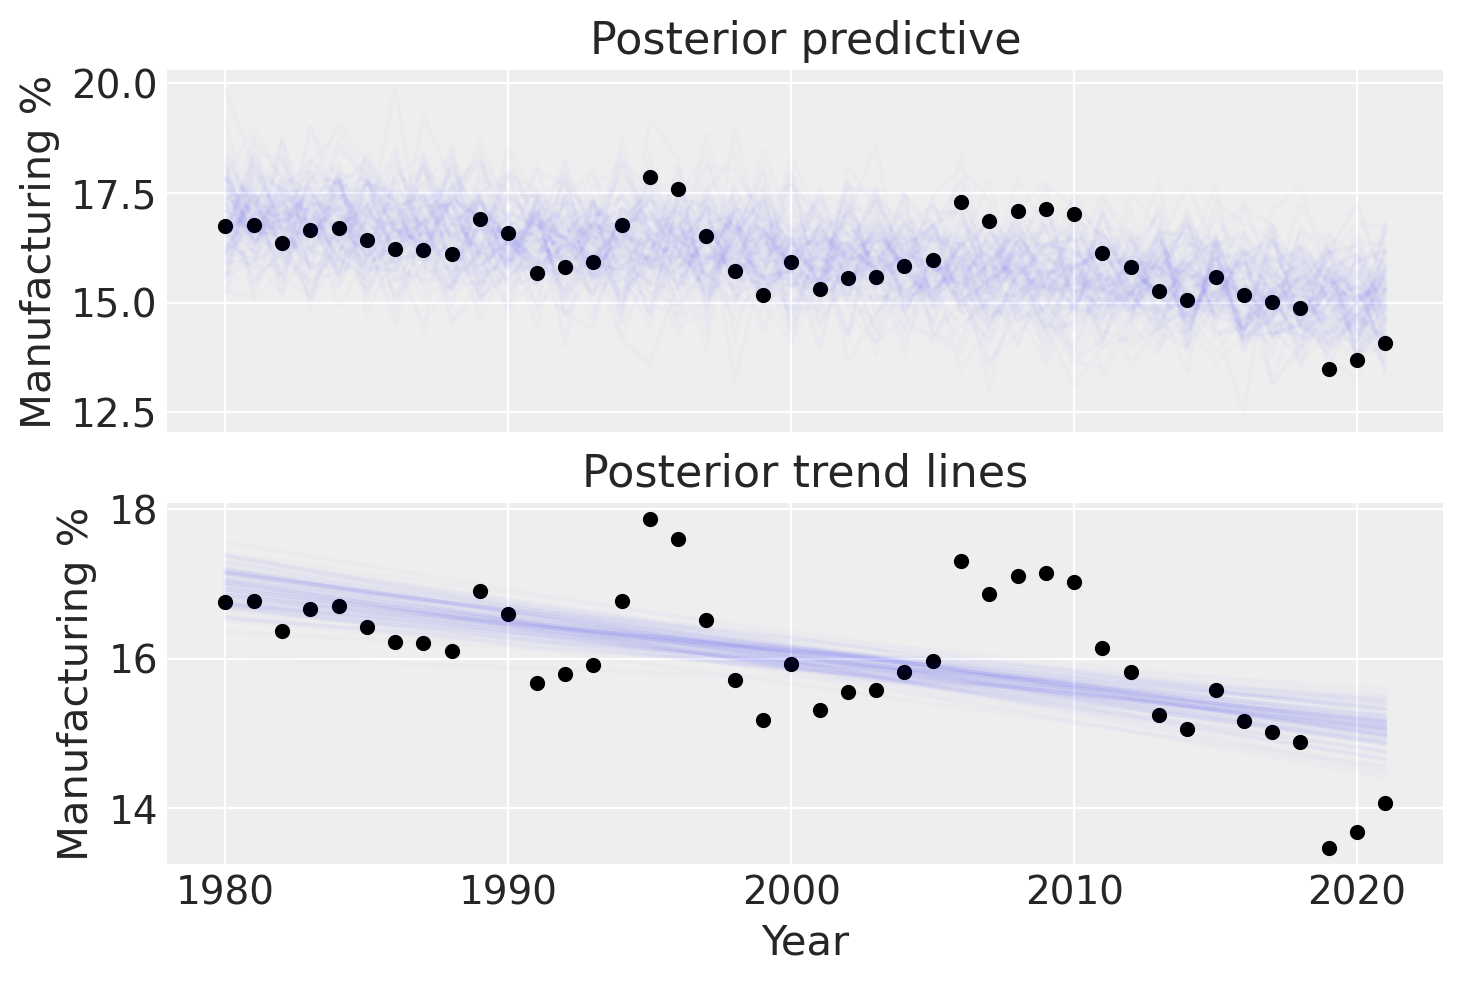

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    data["Year"],
    az.extract(linear_prior, group="posterior_predictive", num_samples=100)["likelihood"]
    * y_max,
    color="blue",
    alpha=0.01,
)
data.plot.scatter(x="Year", y="Manufacturing_value added_%_of_GDP", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")
ax[0].set_ylabel("Manufacturing %")

ax[1].plot(
    data["Year"],
    az.extract(linear_trace, group="posterior", num_samples=100)["trend"] * y_max,
    color="blue",
    alpha=0.01,
)
data.plot.scatter(x="Year", y="Manufacturing_value added_%_of_GDP", color="k", ax=ax[1])
ax[1].set_title("Posterior trend lines");
ax[1].set_ylabel("Manufacturing %")
plt.show()


**Notes:**
- Can't utilize seasonality (no proper setting for the fourier series component) for our task: In general, the interval of seasonality is below 1 year.
- Only use the trend term. But in this case `Prophet` packages are better finding the change points.
- Further step: explore more model setting

# Evaluate of all series

In [16]:
results = pd.DataFrame(columns=['task', 'country', 'MAE', 'RMSE', 'MAPE'])

In [17]:
for task, data_contries in [('Manufacturing', datas_m), ('Service', datas_s)]:
    for con in tqdm(dic_country.keys()):
    # Construct Dataset
        data = data_contries[con].reset_index()
        df_train = data[data['Year'] <= 2016]
        df_test = data[data['Year'] >= 2017]
        y_train = df_train["Manufacturing_value added_%_of_GDP"].to_numpy()
        y_test = df_test["Manufacturing_value added_%_of_GDP"].to_numpy()
        y_train_max = np.max(y_train)
        y_train = y_train / y_train_max

        # Transform data
        t_raw = data["Year"].to_numpy()
        t_min = np.min(t_raw)
        t_max = np.max(t_raw)
        t_all = (t_raw - t_min) / (t_max - t_min)
        t_train = t_all[:len(y_train)]
        t_test = t_all[len(y_train):]

        # Model on trainset
        with pm.Model() as linear:
            α = pm.Normal("α", mu=1, sigma=0.5)
            β = pm.Normal("β", mu=0, sigma=0.5)
            σ = pm.HalfNormal("σ", sigma=0.1)
            t = pm.MutableData('t', t_train)

            trend = pm.Deterministic("trend", α + β * t)
            obs = pm.Normal("obs", mu=trend, sigma=σ, observed=y_train, shape=t.shape)
            idata = pm.sample()

        # Evaluating on testset
        with linear:
            pm.set_data({"t": t_test})
            ppc_test = pm.sample_posterior_predictive(idata)
        y_pred = ppc_test.posterior_predictive['obs'].mean(('chain', 'draw')).to_numpy() * y_train_max
        mae = MAE(y_test, y_pred)
        rmse = MSE(y_test, y_pred, squared=True)
        mape = MAPE(y_test, y_pred)
        results.loc[len(results.index)] = [task, con, mae, rmse, mape]

  0%|          | 0/9 [00:00<?, ?it/s]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


  0%|          | 0/9 [00:00<?, ?it/s]

KeyError: 'Manufacturing_value added_%_of_GDP'

In [ ]:
results